# Planejamento da Solução

## Input

1. Problema de negócio
 - Selecionar os clientes mais valiosos para criar um programa de fidelidade
2. Conjunto de dados
 - Vendas de e-commerce no período de um ano

## Output

1. <b>Indicação das pessoas que farão parte do programa de fidelidade
    - Tabela com: <br>
            |customer_id | is_insider| 
            |    1      |     yes   | 
            |    2      |     no    | 
 
2. <b>Responder as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior valor?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV
        - Baixa recência (compra mais frequentemente)
        - Alto basket size (tamanho de cesta)
        - Baixa probabilidade de churn (periodo que passa e não vai mais comprar)
        - Alta previsão de LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
    - Experiência de compra:
        - Alta média das avaliações
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente (podem ser utilizadas para busca clientes semelhantes)
        - Idade
        - Localização
    - Escrever caacterísticas do consumo
        - Atributos da clusterização
        
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort (como um grupo de pessoas se comporta ao longo do tempo)
        - Sabendo que pessoas que compram calça na primeira compram geram maior faturamento futuro, posso otimizar campanhas
        - Pessoas da localidade X trazem maior faturamento 
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar com uma pessoa do grupo
    

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser não parecida com uma pessoa do grupo (começa a se distanciar do cluster)


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa


# 0.0. IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import plotly.express as px

from matplotlib import pyplot as plt
from IPython.display import HTML

from inflection import underscore
import pickle
import re

In [2]:
from pandas_profiling import ProfileReport

In [125]:

from sklearn import preprocessing as pp
# PCA
from sklearn import decomposition as dd
# TSNE
from sklearn.manifold import TSNE

In [3]:
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics as m

In [4]:
import umap.umap_ as ump

## 0.1. Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container { width:95% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows=50
    pd.set_option('display.expand_frame_repr', False)
       
    sns.set()
    
jupyter_settings()

## 0.2. Loading Data

In [6]:
data_raw = pd.read_csv('../datasets/Ecommerce.csv',encoding='latin-1')
data_raw.drop(columns=['Unnamed: 8'], inplace=True)

# 1.0. PASSO 01 - DATA DESCRIPTION

In [7]:
df1 = data_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename Columns

In [8]:
df1.columns = df1.columns.to_series().apply(underscore)

## 1.2. Data Dimensions

In [9]:
print(f'Counting {df1.shape[0]} rows and {df1.shape[1]} columns')

Counting 541909 rows and 8 columns


## 1.3. Data Types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fillout NA's

In [12]:
df_missing = df1.loc[df1['customer_id'].isna()]
df_missing.shape

(135080, 8)

In [13]:
df_not_missing = df1.loc[~df1['customer_id'].isna()]
df_not_missing.shape

(406829, 8)

In [14]:
# looking for invoice_no with missing customer_id in df_not_missing
list_of_invoice_missing = list(df_missing['invoice_no'].unique())
df_not_missing[df_not_missing['invoice_no'].isin(list_of_invoice_missing)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [15]:
# Feito--> Preencher os customer_id's com id's a partir de 19000 (linhas com o mesmo invoice_no são do mesmo customer_id)
df_for_fill_customer = pd.DataFrame({'invoice_no':list_of_invoice_missing})
df_for_fill_customer['customer_id'] = df_for_fill_customer.index+19000

df_missing = df_missing.merge(df_for_fill_customer, on='invoice_no', how='left', 
                             suffixes=('_delete','')).drop(columns=['customer_id_delete'])

df1 = pd.concat([df_not_missing, df_missing]).reset_index(drop=True)


# # outro método --> faz o merge do df1 e do df_for_fill_customer e depois usa o coalesce :
# df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id'_y])

In [16]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## 1.6. Verifying Types

In [17]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id 
df1['customer_id'] = df1['customer_id'].astype('int64')

df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [19]:
df_num_attibutes = num_attributes.describe()

df_num_attibutes.loc['kurtosis',] = num_attributes.describe().kurtosis().values
df_num_attibutes.loc['skew'] = num_attributes.describe().skew().values

df_num_attibutes = df_num_attibutes.T

df_num_attibutes['range'] = df_num_attibutes['max'] - df_num_attibutes['min']

df_num_attibutes = df_num_attibutes[['min', 'max', 'range', 'mean' , '50%', 'std', 
                  'skew', 'kurtosis']].reset_index().rename(columns={'index': 'attribute', '50%': 'median'})

df_num_attibutes

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.081158,2.557763,6.880051
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759853,2.795606,7.854019
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.411352,2.823097,7.977626


#### 1.7.1. Numerical Attributes - Looking for errors

1. Quantity negativo --> Pode ser devolução

2. unit_price igual a 0 --> promoção? 

In [20]:
# quantity < 0 --> aparenta ser devolução/descontos/etc --> separar entre compras e retornos
print(f"{df1[df1['quantity'] <0].count().values[0]} rows with quantity < 0")

# unit_price == 0 --> nao vi razão aparente, então vou considerar com erro e deleta-las
print(f"{df1[df1['unit_price'] ==0].count().values[0]} rows with unit_price = 0 --> will be deleted")

10624 rows with quantity < 0
2515 rows with unit_price = 0 --> will be deleted


### 1.7.1. Categorical Attributes

In [21]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### invoice no

In [22]:
# invoice no
letter_index_invoice = cat_attributes['invoice_no'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[letter_index_invoice, 'invoice_no'])} rows invoice_no with letters")
print(f"{len(cat_attributes.loc[letter_index_invoice, 'invoice_no'].unique())} unique invoice_no with letters")

9291 rows invoice_no with letters
3839 unique invoice_no with letters


#### stock code

In [23]:
# stock code
only_letters_stock = cat_attributes['stock_code'].apply(lambda x: True if re.search('^[A-Z a-z]+$',x) != None else False)
print(list(cat_attributes.loc[only_letters_stock,'stock_code'].unique()))

# Ação --> Por enquanto retirar ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT',
# 'CRUK', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'B'] --> não vou considerar compras

['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'B']


In [24]:
at_least_oneletter_stock = cat_attributes['stock_code'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[at_least_oneletter_stock, 'stock_code'].unique())} unique stock_code with letters\n")
print(f"{cat_attributes.loc[at_least_oneletter_stock, 'stock_code'].sample(5).values} ...")

1124 unique stock_code with letters

['15044A' '84531A' '84536B' '85123A' '85123A'] ...


#### description

In [25]:
# Ação --> Deletar description

#### country

In [26]:
# Ação --> Deletar European Community e Unspecified
# Todo --> Tentar alterar os nomes 
cat_attributes['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

# 2.0. PASSO 02 - FILTRAGEM DE VARIÁVEIS

In [27]:
df2 = df1.copy()

In [28]:
### Categorical Attibutes ###
# stock code != ['POST', 'D', 'M', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 
                                   'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'B'])]

# description
df2 = df2.drop(columns=['description'])

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

In [29]:
### Numerical Attibutes ###

# unit_price
# df2.loc[df2['unit_price'] > 0.01, :].sort_values('unit_price', ascending=True)
df2 = df2.loc[df2['unit_price'] > 0.01, :]

# quantity
df_purchases = df2.loc[df2['quantity'] > 0]
df_returns = df2.loc[df2['quantity'] < 0]

# 3.0. PASSO 03 - FEATURE ENGINEERING

In [70]:
df3 = df2.copy()

## 3.1. Feature Engineering

In [71]:
# creating a reference dataframe --> only id's
df_reference = df3[['customer_id']].drop_duplicates(ignore_index=True)

### 3.1.1. Revenue

In [72]:
# Revenue --> Faturamento --> Quantity * Price
df_purchases.loc[:, 'revenue'] = (df_purchases['quantity'] * df_purchases['unit_price'])
revenue_per_client = df_purchases[['customer_id', 'revenue']].groupby('customer_id').sum()
df_reference = df_reference.merge(revenue_per_client, on='customer_id', how='left')

C:\Users\Miguel\AppData\Local\Temp\ipykernel_12964\2578962312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchases.loc[:, 'revenue'] = (df_purchases['quantity'] * df_purchases['unit_price'])


### 3.1.2. Recency

In [73]:
# Recency --> Today - Last day purchase
last_buy_date_per_client = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_reference = df_reference.merge(last_buy_date_per_client, on='customer_id', how='left').rename(columns={'invoice_date': 'recency'})
df_reference['recency'] = (df_purchases['invoice_date'].max() - df_reference['recency']).dt.days

### 3.1.3. Quantity of orders

In [74]:
# Quantity of orders
helper_group = df_purchases[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).count().reset_index()
quantity_per_client = helper_group[['customer_id', 'quantity']].groupby('customer_id').count().reset_index()
df_reference = df_reference.merge(quantity_per_client, on='customer_id', how='left').rename(columns={'quantity': 'quantity_orders'})

### 3.1.4. Total quantity of items purchased

In [75]:
# Total quantity of items
quantity_per_client = df_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_reference = df_reference.merge(quantity_per_client, on='customer_id', how='left').rename(columns={'quantity': 'quantity_items_purchased'})

### 3.1.5. Avg Ticket

In [76]:
# Avg ticket
df_reference['avg_ticket'] = df_reference['revenue'] / df_reference['quantity_orders']

### 3.1.6. Avg Recency Days

In [77]:
# Avg Recency Days
df_aux = df_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=True)

df_aux['next_customer_id'] = df_aux['customer_id'].shift(1)

df_aux['last_buy_diff'] = df_aux['invoice_date'].diff(1)

# when the customer_id != next_customer_id --> last_buy_diff will be np.nan
df_aux['last_buy_diff'] = df_aux.apply(lambda x: x['last_buy_diff'] if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

# desloca para cima e calcula os NA's serão os que estão com recencia igual data atual - data da compra (ultima compra realizada)
df_aux['last_buy_diff'] = df_aux['last_buy_diff'].shift(-1)

# preenche os NA's com a recencia em relação a data atual
df_aux['avg_recency'] = df_aux['last_buy_diff'].fillna(df3['invoice_date'].max() - df_aux['invoice_date']).dt.days

avg_recency_by_client = df_aux[['customer_id', 'avg_recency']].groupby('customer_id').mean()

df_reference = df_reference.merge(avg_recency_by_client, on='customer_id', how='left')

### 3.1.7. Time in base

In [78]:
#Time in base = Today - Min date of his buy

min_date_by_user = (df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg(min_=('invoice_date', 'min'))).reset_index()

min_date_by_user['time_in_base'] = (df_purchases['invoice_date'].max() - min_date_by_user['min_']).dt.days + 1 


df_reference = df_reference.merge(min_date_by_user[['customer_id', 'time_in_base']], on='customer_id', how='left')

### 3.1.8. Frequency

In [79]:
# Frequency--> Quantity of orders / Time in base 
df_reference['frequency'] = df_reference['quantity_orders'] / df_reference['time_in_base']

### 3.1.9. Frequency between first and last purschase

In [80]:
# Frequency between purchases --> num of orders/ (Max date of his buy - Min date of his buy ) 
df_aux = (df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg(max_=('invoice_date', 'max'),
                                                                min_=('invoice_date', 'min'),
                                                                buys_=('invoice_no', 'count'))).reset_index()

df_aux['days_'] = (df_aux['max_'] - df_aux['min_'] ).dt.days +1
df_aux['frequency_btwn_purchases'] = df_aux.apply(lambda x: (x['buys_'] / x['days_'])if x['days_'] != 0 else 0, axis=1)

# frequency 0 --> means only 1 buy 

df_reference = df_reference.merge(df_aux[['customer_id', 'frequency_btwn_purchases']], on='customer_id', how='left')

### 3.1.10. Avg Basket Size

In [81]:
# Avg Basket Size --> How many items / Homw many orders
df_reference['avg_basket_size'] = df_reference['quantity_items_purchased'] / df_reference['quantity_orders']

### 3.1.11. Avg Unique items in Basket Size

In [82]:
df_aux = (df_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg(n_purchases = ('invoice_no', 'nunique'),
                                                                              n_products = ('stock_code', 'nunique')).reset_index())

df_aux['avg_unique_basked_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_reference = df_reference.merge(df_aux[['customer_id', 'avg_unique_basked_size']], on='customer_id', how='left')

### 3.1.12. Total quantity of products returned

In [83]:
# Total quantity of products returned
quantity_per_client = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_reference = df_reference.merge(quantity_per_client, on='customer_id', how='left').rename(columns={'quantity': 'quantity_items_returned'})


# Changing for positive values
df_reference['quantity_items_returned'] = df_reference['quantity_items_returned'] * -1

# Return NA --> 0 --> empty means no products retured
df_reference['quantity_items_returned'] = df_reference['quantity_items_returned'].fillna(0) 

### 3.1.13. Monetary returned

In [84]:
# Revenue --> Faturamento --> Quantity * Price
df_returns.loc[:, 'monetary_returned'] = (df_returns['quantity'] * df_returns['unit_price'])
monetary_returned_per_client = df_returns[['customer_id', 'monetary_returned']].groupby('customer_id').sum()
df_reference = df_reference.merge(monetary_returned_per_client, on='customer_id', how='left')

# Changing for positive values
df_reference['monetary_returned'] = df_reference['monetary_returned'] * -1

# NA --> 0 --> empty means no monetary retured
df_reference['monetary_returned'] = df_reference['monetary_returned'].fillna(0) 

C:\Users\Miguel\AppData\Local\Temp\ipykernel_12964\3292527754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns.loc[:, 'monetary_returned'] = (df_returns['quantity'] * df_returns['unit_price'])


### 3.1.14. CORRECTING

In [85]:
df_reference.isna().sum()

customer_id                  0
revenue                     67
recency                     67
quantity_orders             67
quantity_items_purchased    67
avg_ticket                  67
avg_recency                 67
time_in_base                67
frequency                   67
frequency_btwn_purchases    67
avg_basket_size             67
avg_unique_basked_size      67
quantity_items_returned      0
monetary_returned            0
dtype: int64

In [86]:
# Dropar os outros NA's --> Suas purchases foram eliminadas por algum processo anterior
df_reference = df_reference.dropna(axis=0).reset_index(drop=True)

# changing types
df_reference[['recency', 
              'quantity_orders', 
              'time_in_base',
              'quantity_items_purchased',
              'quantity_items_returned']] = df_reference[['recency', 
                                                             'quantity_orders', 
                                                             'time_in_base',
                                                             'quantity_items_purchased',
                                                             'quantity_items_returned']].astype('int64')

df_reference.head()

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
0,17850,5391.21,372,34,1733,158.565000,186.500000,374,0.090909,17.000000,50.970588,0.617647,40,102.58
1,13047,3232.59,56,9,1390,359.176667,53.285714,374,0.024064,0.028302,154.444444,11.666667,35,143.49
2,12583,6705.38,2,15,5028,447.025333,24.866667,374,0.040107,0.040323,335.200000,7.600000,50,76.04
3,13748,948.25,95,5,439,189.650000,93.250000,374,0.013369,0.017921,87.800000,4.800000,0,0.00
4,15100,876.00,333,3,80,292.000000,124.333333,374,0.008021,0.073171,26.666667,0.333333,22,240.90


# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

1. Cluster Coesos e Separados
- No modelo de negócio de e-commerce é mais díficil, pois abrange muitas faixas de preço proximas
- Muitas pessoas compram pouco e poucas pessoas compram muito

2. Buscar variabilidade
 - Mínimo, Máximo, Range (Dispersão)
 - Média e Mediana
 - Desvio Padrão e Variância
 - Coeficiente de Variação
 - Distribuição

In [87]:
df4 = df_reference.copy()
pickle.dump(df4, open('../datasets/intermediary_data_df4.pkl', 'wb'))

## 4.1. Analise Univariada

In [88]:
profile = ProfileReport(df4)
profile.to_file('../EDA/univariate_analysis.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1. Revenue

In [49]:
df4[df4['revenue'] == 279138.02]
# ok

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
889,14646,279138.02,1,72,196844,3876.916944,7.866667,355,0.202817,0.20339,2733.944444,28.611111,288,360.0


### 4.1.2. Avg Ticket

In [50]:
df4[df4['avg_ticket'] > 15000]
# 12346 and 16446 --> Basicamente compraram e retornaram tudo que compraram --> serão removidos

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
1148,12346,77183.60,325,1,74215,77183.60,325.0,326,0.003067,1.000000,74215.0,1.0,74215,77183.6
2619,16446,168472.50,0,2,80997,84236.25,102.5,206,0.009709,0.009709,40498.5,1.5,80995,168469.6
4468,19296,18745.86,353,1,2853,18745.86,353.0,354,0.002825,1.000000,2853.0,186.0,0,0.0
4795,20055,21389.60,255,1,5963,21389.60,255.0,256,0.003906,1.000000,5963.0,138.0,0,0.0
5564,22312,52940.94,32,1,14149,52940.94,32.0,33,0.030303,1.000000,14149.0,101.0,0,0.0
5594,22383,50653.91,25,1,13956,50653.91,25.0,26,0.038462,1.000000,13956.0,99.0,0,0.0


### 4.1.6. Avg Recency Days

### 4.1.7. Time in base

### 4.1.8. Frequency

### 4.1.9. Frequency between first and last purschase

### 4.1.10. Avg Basket Size

### 4.1.11. Avg Unique items in Basket Size

### 4.1.12. Total quantity of products returned

### 4.1.13. Monetary returned

## 4.2. Analise Bivariada

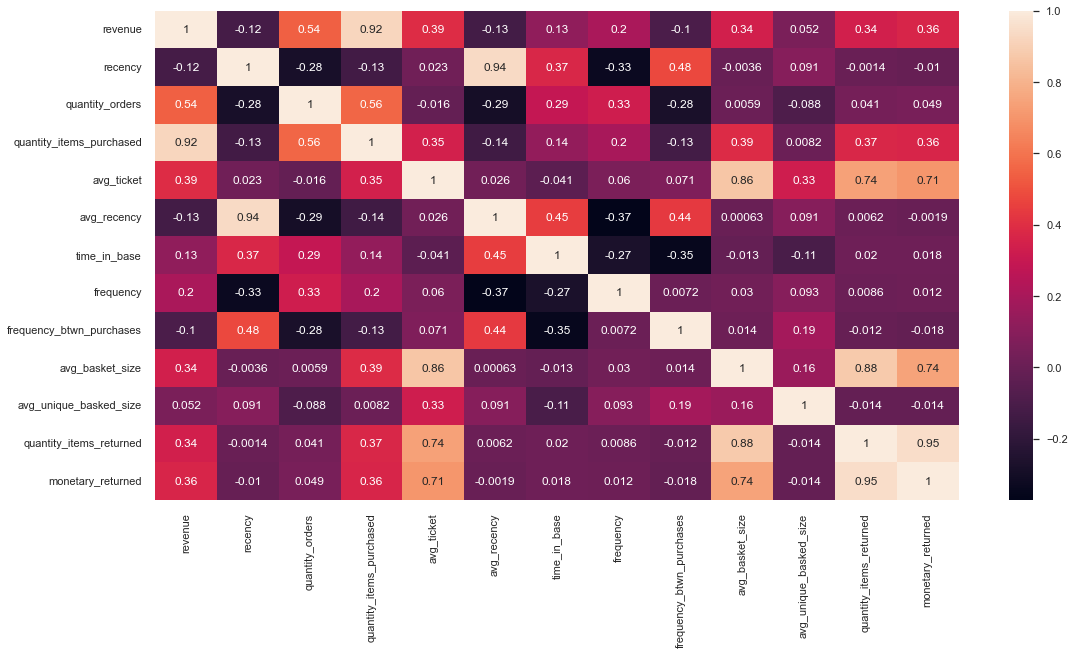

In [51]:
plt.figure(figsize=(18,9))
correlation = df4.drop(columns=['customer_id']).corr(method='pearson')
sns.heatmap(correlation, annot=True)
plt.show()

In [52]:
# plt.figure(figsize=(18,9))
# df_pairplot = df4.drop(columns=['customer_id'])
# sns.pairplot(df_pairplot)
# plt.show()

## 4.3. Estudo do Espaço

In [91]:
df43 = df4.drop(columns=['customer_id']).copy()

In [104]:
minmax = pp.MinMaxScaler()

data_scaled = minmax.fit_transform(df43)

df43_scaled = pd.DataFrame(data_scaled, columns=list(df43.columns))

df43_scaled.head()

,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
0,0.019312,0.997319,0.160976,0.008799,0.001877,0.500000,1.0,0.088472,1.000000,0.000673,0.000377,0.000494,0.000609
1,0.011579,0.150134,0.039024,0.007056,0.004259,0.142857,1.0,0.021448,0.001345,0.002068,0.010342,0.000432,0.000852
2,0.024020,0.005362,0.068293,0.025538,0.005302,0.066667,1.0,0.037534,0.002052,0.004503,0.006674,0.000617,0.000451
3,0.003396,0.254692,0.019512,0.002225,0.002246,0.250000,1.0,0.010724,0.000734,0.001170,0.004149,0.000000,0.000000
4,0.003137,0.892761,0.009756,0.000401,0.003461,0.333333,1.0,0.005362,0.003985,0.000346,0.000120,0.000272,0.001430


### 4.3.1. PCA

In [118]:
X = df43_scaled.copy()

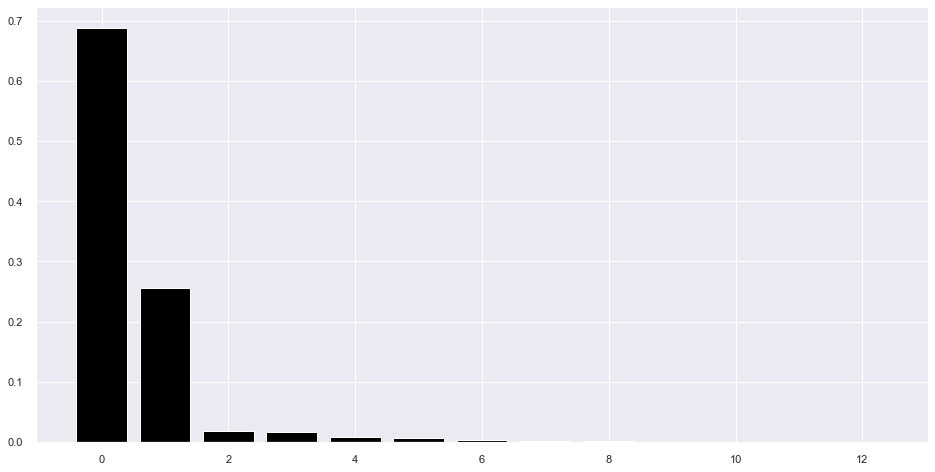

In [119]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

df_pca = pd.DataFrame(principal_components)

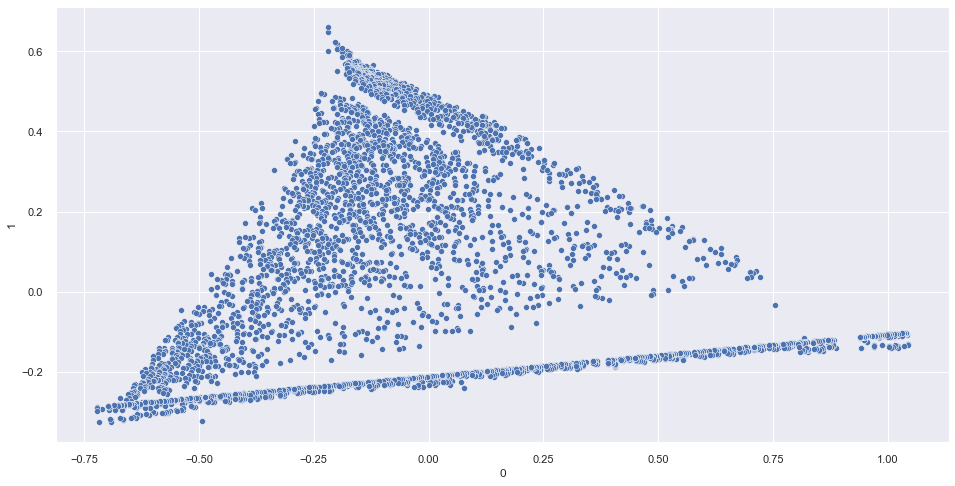

In [121]:
sns.scatterplot(x=0, y=1, data= df_pca);

### 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

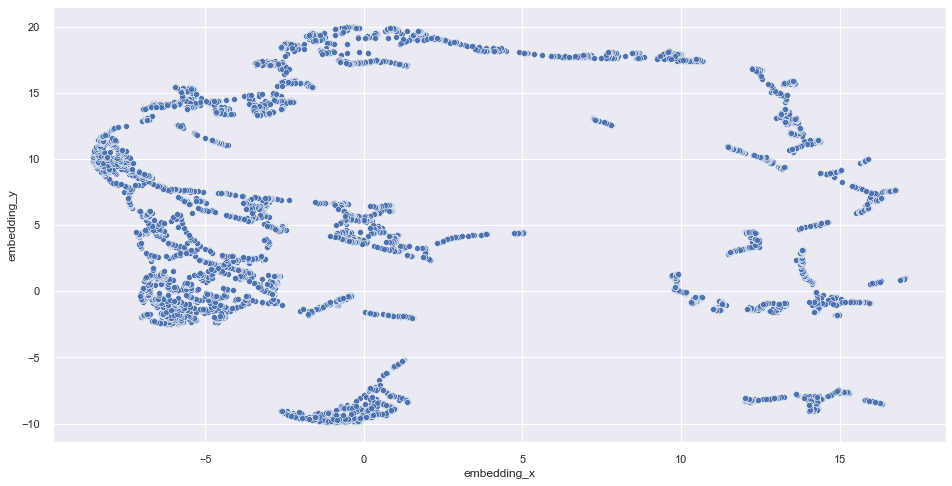

In [122]:
reducer = ump.UMAP(random_state=99) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_pca, x='embedding_x', y='embedding_y')

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

### 4.3.3. t-SNE

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

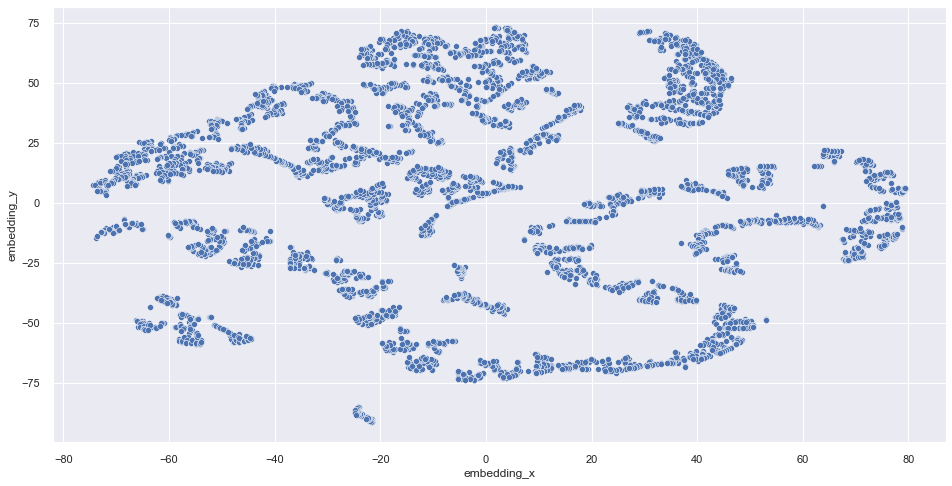

In [126]:
reducer = TSNE(n_components=2 , random_state=99, n_jobs=-1) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_pca, x='embedding_x', y='embedding_y')

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

### 4.3.4. Tree-Based Embedding

In [127]:
X.head()

,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
0,0.019312,0.997319,0.160976,0.008799,0.001877,0.500000,1.0,0.088472,1.000000,0.000673,0.000377,0.000494,0.000609
1,0.011579,0.150134,0.039024,0.007056,0.004259,0.142857,1.0,0.021448,0.001345,0.002068,0.010342,0.000432,0.000852
2,0.024020,0.005362,0.068293,0.025538,0.005302,0.066667,1.0,0.037534,0.002052,0.004503,0.006674,0.000617,0.000451
3,0.003396,0.254692,0.019512,0.002225,0.002246,0.250000,1.0,0.010724,0.000734,0.001170,0.004149,0.000000,0.000000
4,0.003137,0.892761,0.009756,0.000401,0.003461,0.333333,1.0,0.005362,0.003985,0.000346,0.000120,0.000272,0.001430


In [139]:
from sklearn import ensemble as en

In [147]:
# training dataset
X = df4.drop(columns=['customer_id', 'revenue'])
y = df4['revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=700, random_state=99)

# model training
rf_model.fit(X, y)

# dataframe Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

- Perco explicabildade, porém a solução funciona porque não preciso de explicabilidade como os vizinhos são construidos e sim explicar as variáveis em relação ao clusters
- Ex: Esse cluster em média compra x, tem recencia y, etc

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

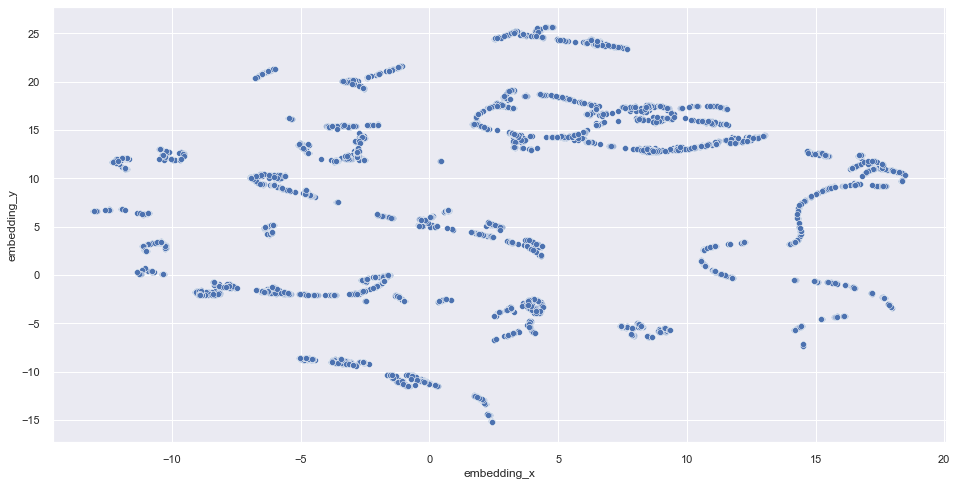

In [148]:
reducer = ump.UMAP(random_state=99) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(df_leaf)

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_pca, x='embedding_x', y='embedding_y')

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

# 5.0. PASSO 05 - PREPARAÇAO DOS DADOS

In [53]:
#df4 = pd.read_pickle('../datasets/intermediary_data_df4.pkl')
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Scaling

## 5.3. Transformacao

### 5.3.1. Encoding

### 5.3.2. Response Variable Transformation

### 5.3.3. Nature Transformation

# 6.0. PASSO 06 - FEATURE SELECTION

In [54]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test

## 6.2. Feature Selection

# 7.0. PASSO 07 - FINDING THE NUMBER OF CLUSTERS

HYPERPARAMETER FINE TUNING

In [55]:
df7 = df6.copy()

In [56]:
X = df7.drop(columns=['customer_id'])

In [57]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluste Sum of Square (WSS)

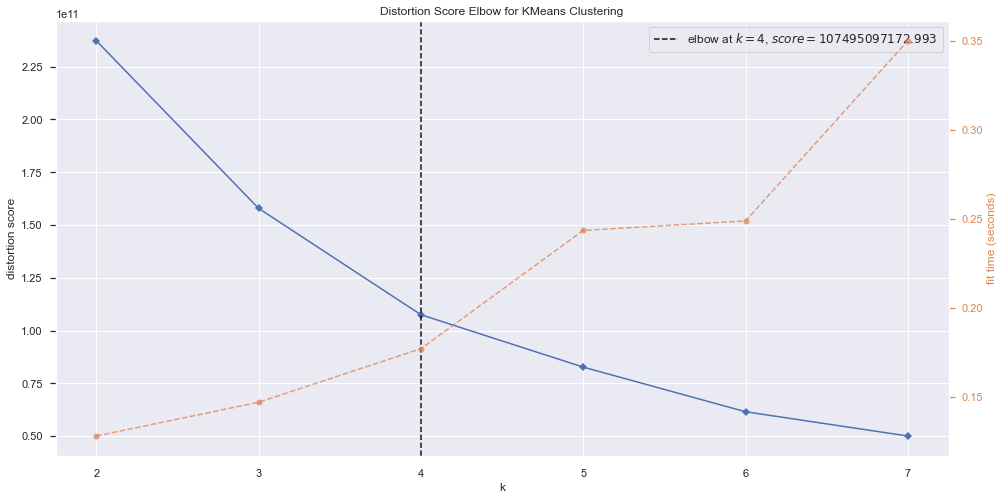

In [58]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score (SS)

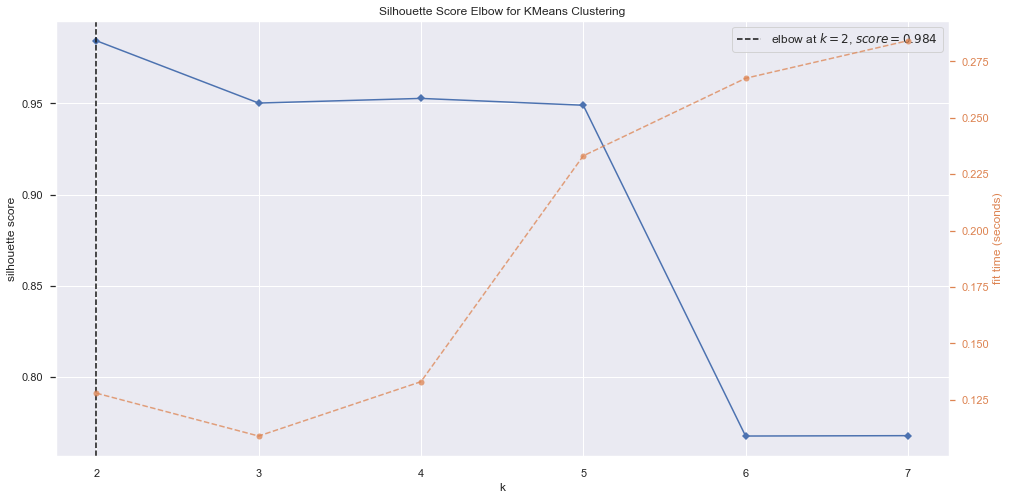

In [59]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette',timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Analysis

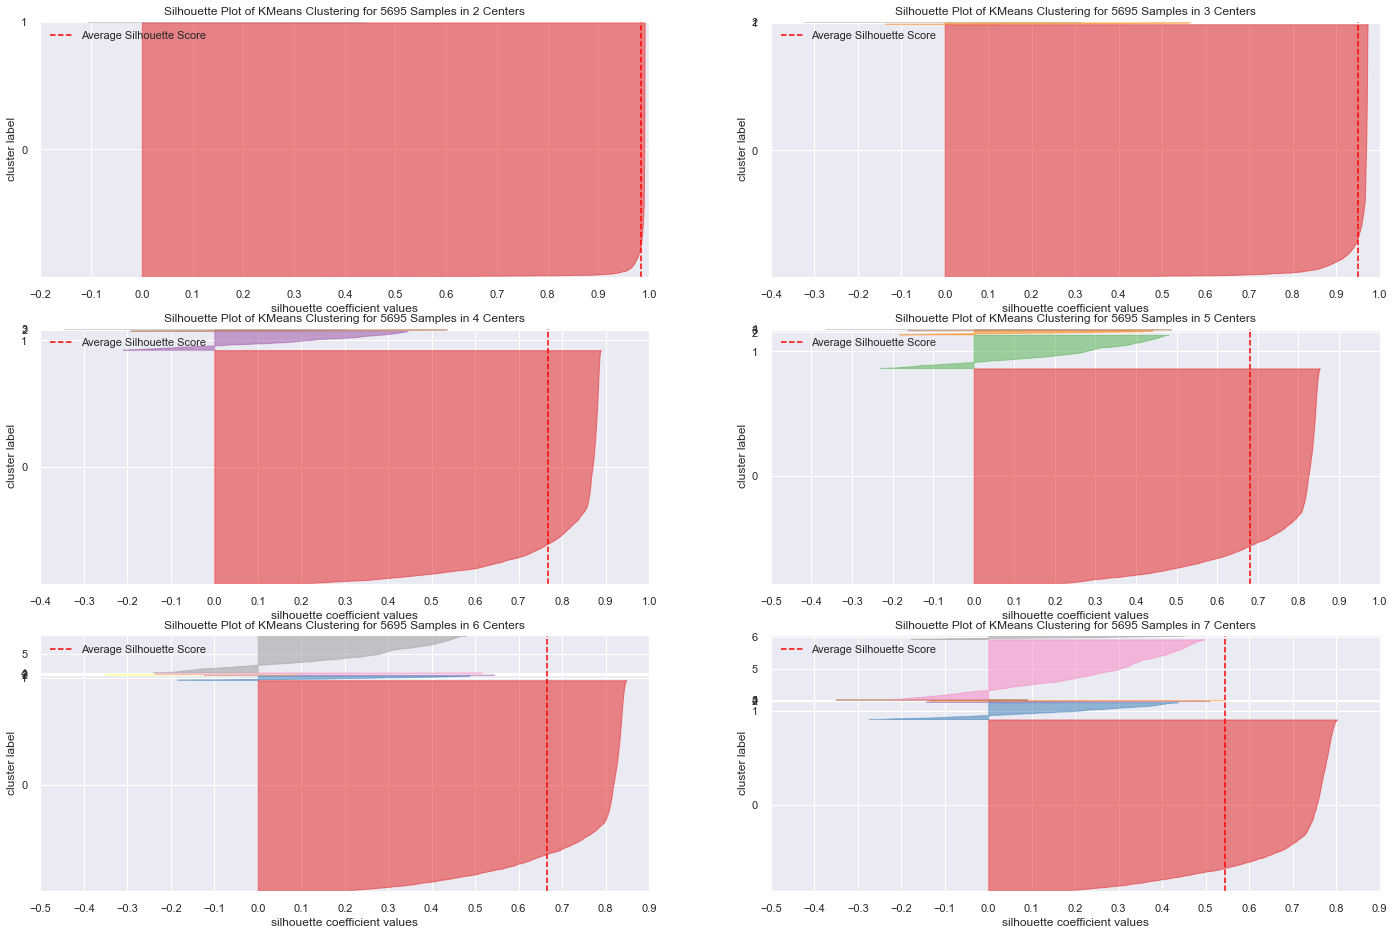

In [60]:
fig, ax = plt.subplots(3,2,figsize=(24,16))
for k in clusters:
    km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)
    
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0. PASSO 08 - MODEL TRAINING

## 8.1. K-Means

In [61]:
# model definition
k = 5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1. Cluster Validation

In [62]:
# WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

# SS
print(f'SS: {m.silhouette_score(X, labels, metric="euclidean"):.3f}')

WSS: 127996649056.38
SS: 0.681


# 9.0. PASSO 09 - CLUSTER ANALYSIS

In [63]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned,cluster
0,17850,5391.21,372,34,1733,158.565000,186.500000,374,0.090909,17.000000,50.970588,8.735294,40,102.58,1
1,13047,3232.59,56,9,1390,359.176667,53.285714,374,0.024064,0.028302,154.444444,19.000000,35,143.49,1
2,12583,6705.38,2,15,5028,447.025333,24.866667,374,0.040107,0.040323,335.200000,15.466667,50,76.04,1
3,13748,948.25,95,5,439,189.650000,93.250000,374,0.013369,0.017921,87.800000,5.600000,0,0.00,0
4,15100,876.00,333,3,80,292.000000,124.333333,374,0.008021,0.073171,26.666667,1.000000,22,240.90,0


## 9.1. Visualization Inspection

In [64]:
# fig = px.scatter_3d(df9, x='recency', y='frequency', z='revenue', color='cluster')
# fig.show()

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


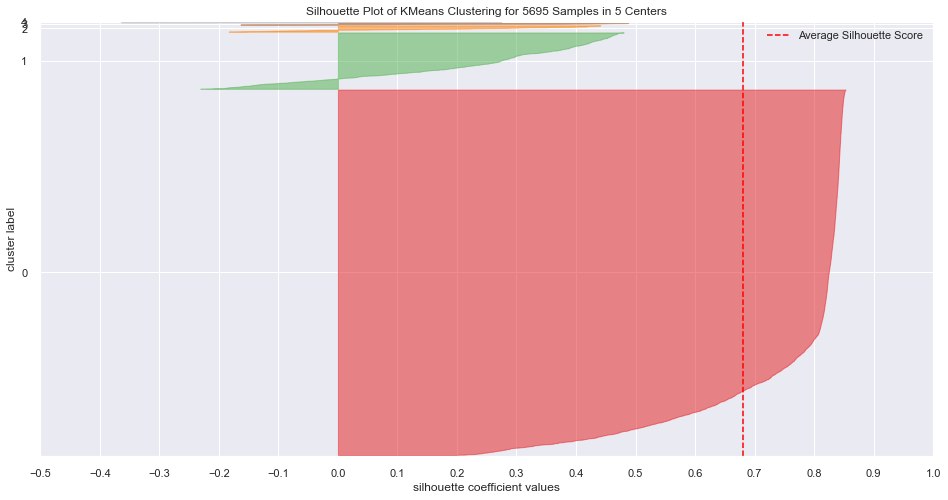

In [65]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.1.1. 2d plot

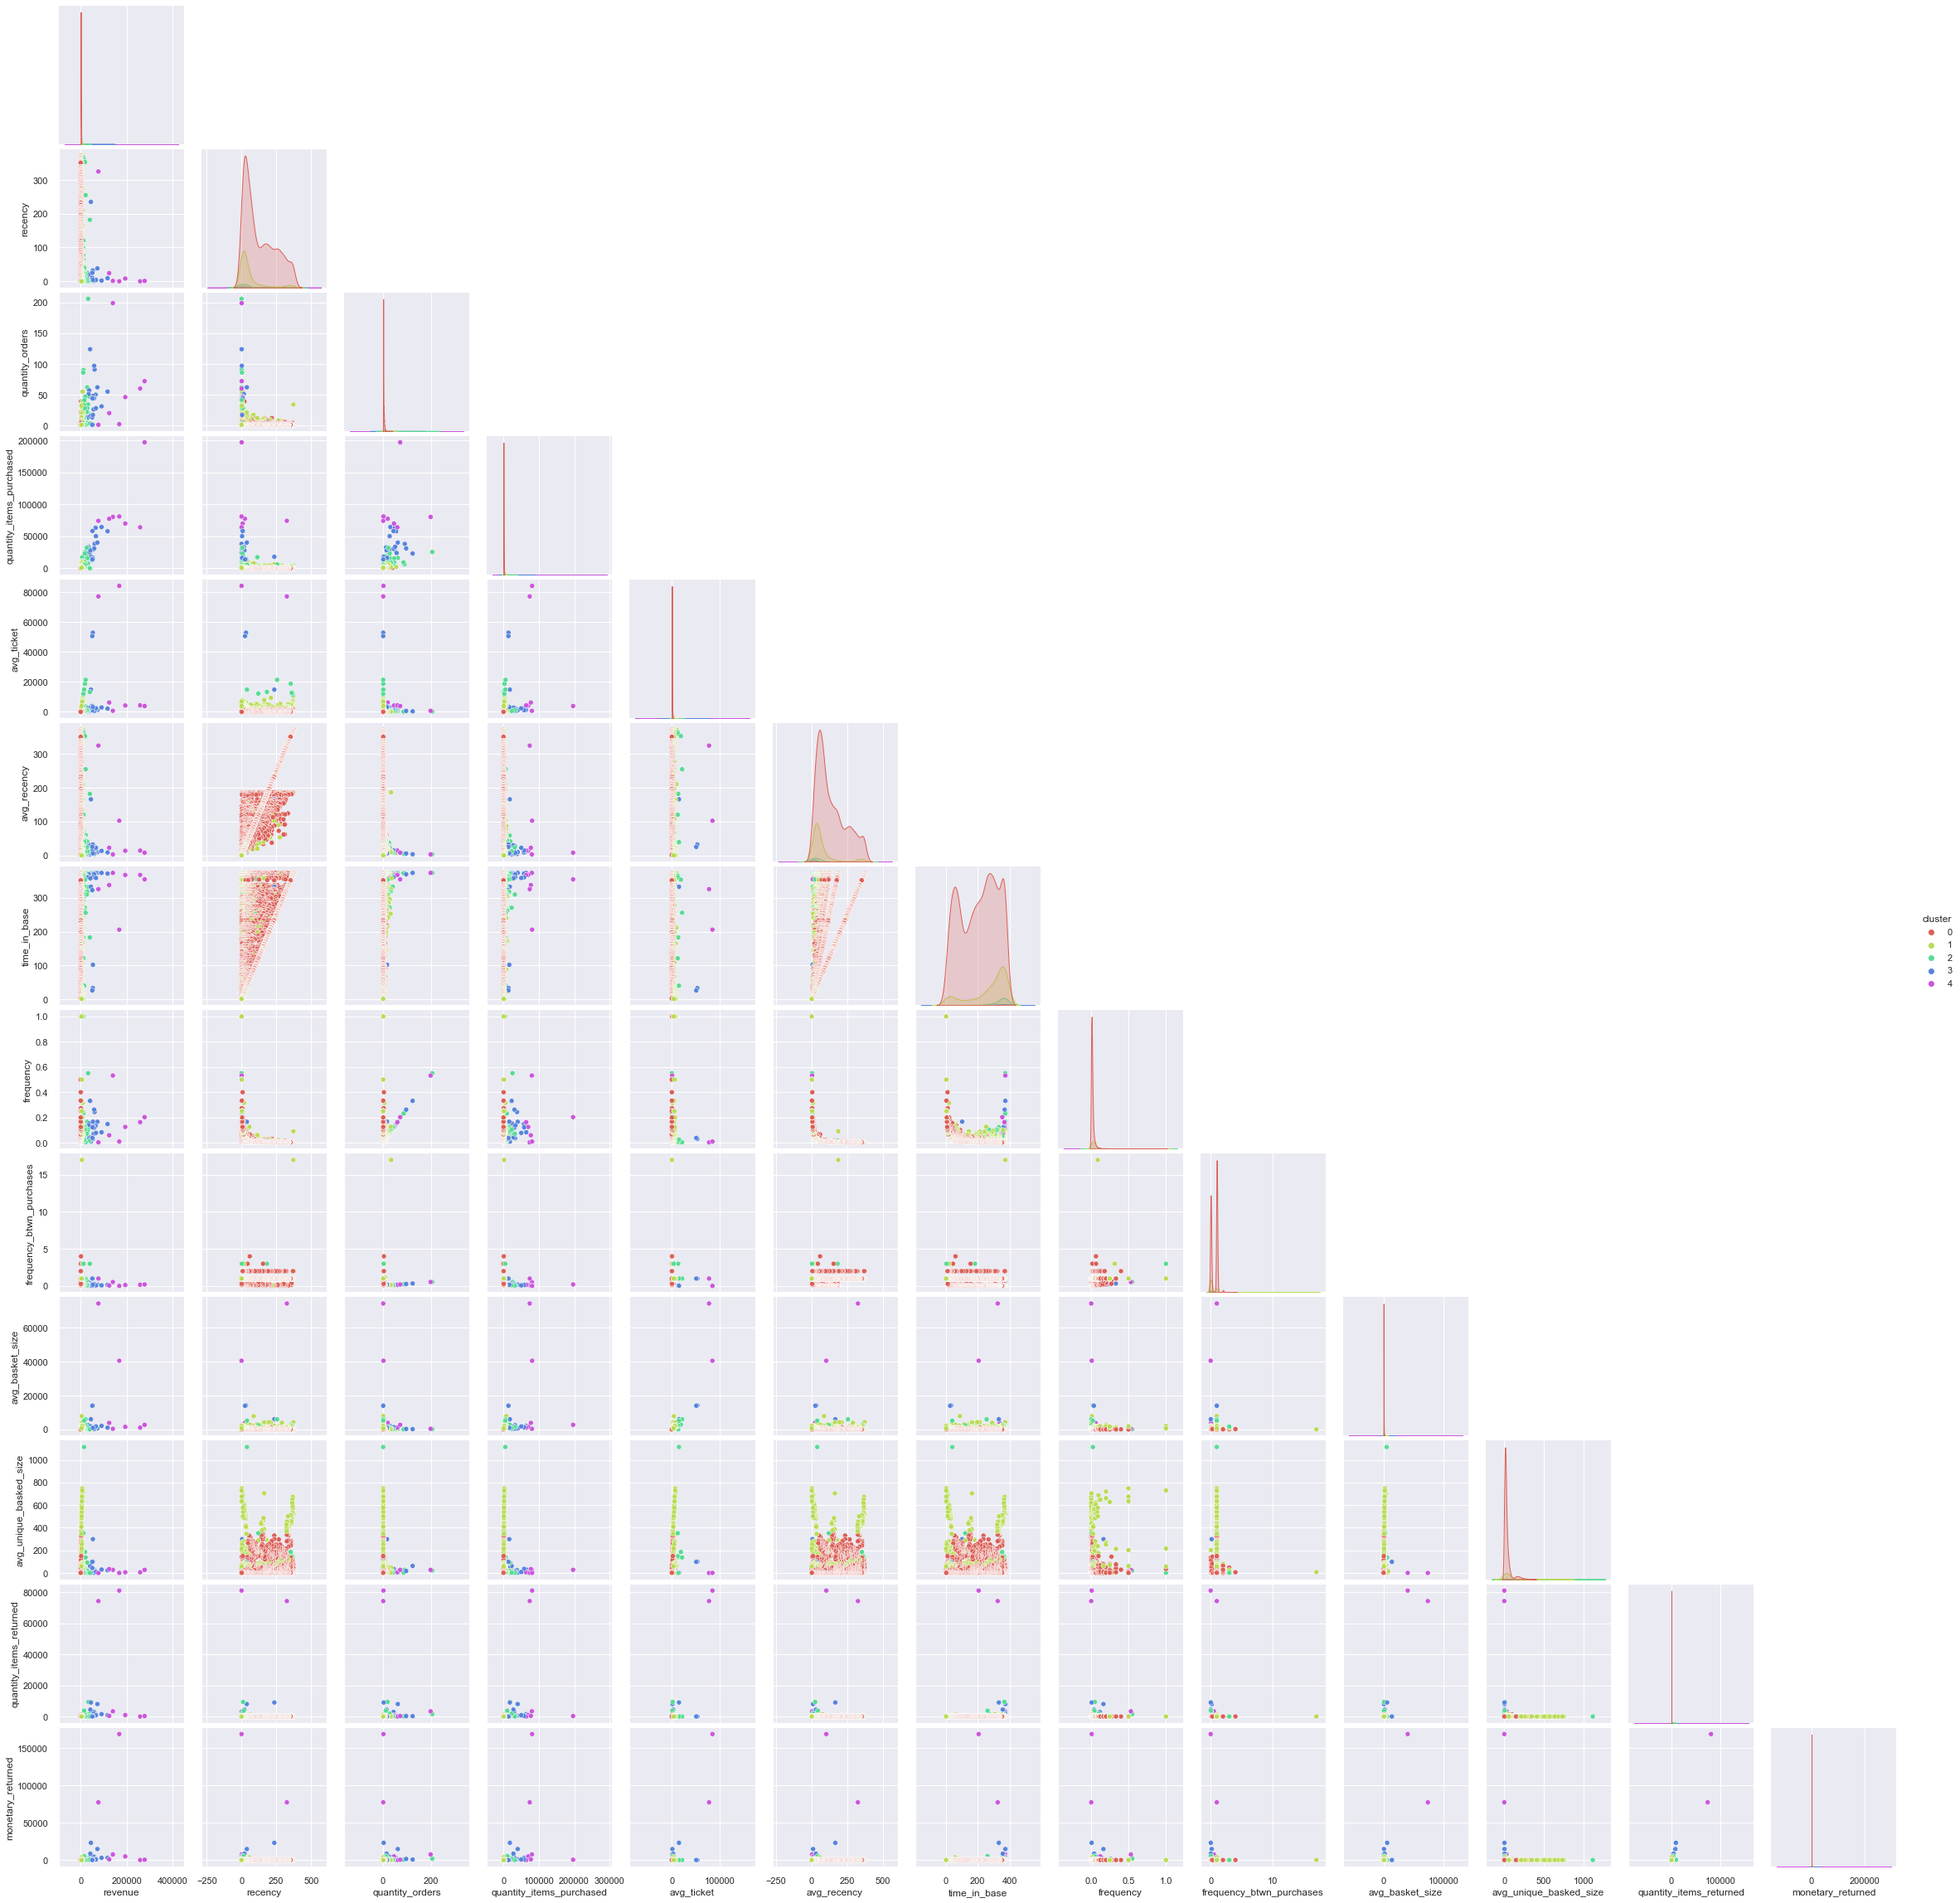

In [66]:
df_viz = df9.drop(columns=['customer_id'])
sns.pairplot(df_viz, hue='cluster', corner=True, palette=sns.color_palette("hls", len(df9['cluster'].unique())));

## 9.1.2. Machine Learning - Manifold

- Redução de dimensionalidade
1. PCA - Matrix, Espaço de Distância - Espaço de Hilbert - 9 Condições - Colorários

2. UMAP, t-SNE (2009) - Manifold - Topologia

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

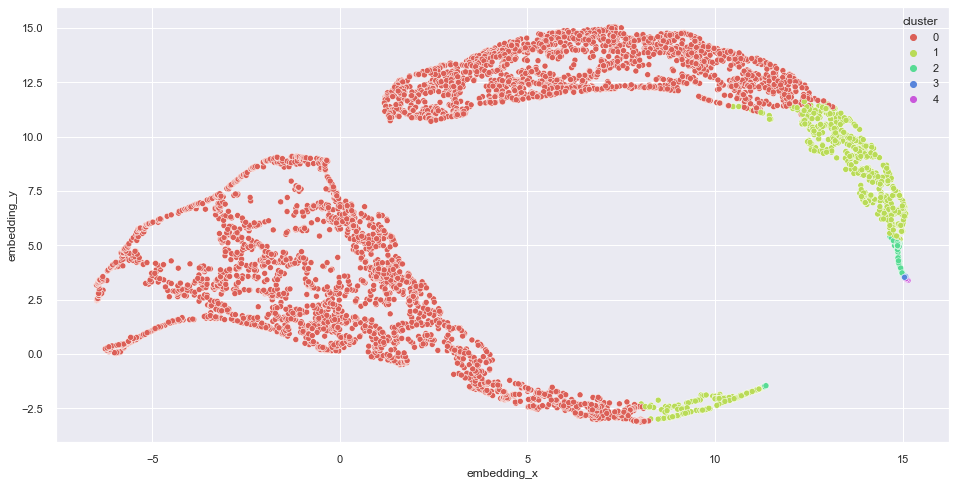

In [67]:
# projeção do X em outro espaço
reducer = ump.UMAP(random_state=99,n_neighbors=20 ) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_viz, x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())))

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

## 9.2. Cluster Profile

In [68]:
# Number of customers
df_profile = pd.DataFrame({'count': df9['cluster'].value_counts(), 
                                    'percent': df9['cluster'].value_counts(normalize=True) * 100})

df_profile.index.name = 'cluster'

df_profile = df_profile.reset_index()

# Average in other metrics
average_metrics_by_cluster = df9.drop(columns=['customer_id']).groupby('cluster').mean().reset_index()


df_profile = df_profile.merge(average_metrics_by_cluster, on='cluster').sort_values('revenue', ascending=False)
df_profile

,cluster,count,percent,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
4,4,7,0.122915,177716.780000,51.285714,57.142857,91972.714286,25826.823232,69.769806,333.571429,0.156413,0.300161,17758.535199,15.682581,22887.000000,37028.342857
3,3,21,0.368745,56737.085238,20.333333,41.476190,33783.047619,7112.360478,22.053685,320.380952,0.120820,0.216229,2526.101956,39.242574,1605.285714,3396.133333
2,2,84,1.474978,16135.114286,36.761905,22.571429,8615.321429,2299.487200,48.031317,334.000000,0.075943,0.219783,794.880619,44.317142,326.666667,429.710476
1,1,746,13.099210,4278.455013,56.718499,7.955764,2317.107239,1373.962557,68.202291,270.254692,0.041479,0.287856,569.056893,92.701792,29.697051,67.894504
0,0,4837,84.934153,680.254819,128.095720,2.203432,365.492867,365.347079,134.475527,206.430639,0.018688,0.595115,177.622389,31.826734,5.092413,11.010889


In [69]:
for _,linha in df_profile.iterrows():
    print(f"Cluster {linha['cluster']+1:.0f}")
    print(f"Número de clientes: {linha['count']:.0f} ({linha['percent']:.2f}% da base)")
    print(f"Recência em média: {linha['recency']:.2f} dias")
    print(f"Frequência média: {linha['frequency']:.2f} compras")
    print(f"Receita em média: U$ {linha['revenue']:,.2f}")
    print(f"AVG Ticket: U$ {linha['avg_ticket']:,.2f}/compra")
    print('\n')

Cluster 5
Número de clientes: 7 (0.12% da base)
Recência em média: 51.29 dias
Frequência média: 0.16 compras
Receita em média: U$ 177,716.78
AVG Ticket: U$ 25,826.82/compra


Cluster 4
Número de clientes: 21 (0.37% da base)
Recência em média: 20.33 dias
Frequência média: 0.12 compras
Receita em média: U$ 56,737.09
AVG Ticket: U$ 7,112.36/compra


Cluster 3
Número de clientes: 84 (1.47% da base)
Recência em média: 36.76 dias
Frequência média: 0.08 compras
Receita em média: U$ 16,135.11
AVG Ticket: U$ 2,299.49/compra


Cluster 2
Número de clientes: 746 (13.10% da base)
Recência em média: 56.72 dias
Frequência média: 0.04 compras
Receita em média: U$ 4,278.46
AVG Ticket: U$ 1,373.96/compra


Cluster 1
Número de clientes: 4837 (84.93% da base)
Recência em média: 128.10 dias
Frequência média: 0.02 compras
Receita em média: U$ 680.25
AVG Ticket: U$ 365.35/compra




# 10.0. PASSO 10 - DEPLOY TO PRODUCTION